In [1]:
%matplotlib inline

import os
import gc

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from glob import glob
from pprint import pprint
#from process import process_one_file
#print (glob('*.xy'))  #['file1.txt','file2.txt','file3.txt']


In [2]:
# from functions.array_process_functions import *

from diffpy.pdfgetx.functs import loadData
from diffpy.pdfgetx.pdfgetter import PDFGetter
from diffpy.srfit.pdf.characteristicfunctions import lognormalSphericalCF, sphericalCF

from numpy import pi

from pyobjcryst.crystal import CreateCrystalFromCIF

from diffpy.srfit.pdf import PDFParser, PDFGenerator
from diffpy.srfit.fitbase import Profile
from diffpy.srfit.fitbase import FitContribution, FitRecipe
from diffpy.srfit.fitbase import FitResults

import cPickle as pickle

# from gaussianrecipe import scipyOptimize

from scipy.optimize.minpack import leastsq
from scipy.optimize import fmin


## Utils1

In [16]:
def load_data(filepath):
    data1 = np.genfromtxt(filepath+'.chi',skip_header=4).T # transpose 
    q = np.array(data1[0])
    I = np.array(data1[1])
    return q, I

def scalebtoa(ar,ag,bg,rmin=8,rmax=14): # rmin and rmax are refirring to q in this version
    """scale the G(r) B to A and return rescaled B
   
    arguments
    ar - array of x-values (both datasets on the same grid) -
    ag - array of g values for curve A
    bg - array of g values for curve B
    rmin - float of lower bound on range for rescaling
    rmax -  float on upper bound on range
   
    return
    rescaled bg
    """

   
    p=[1.0]
    # set the range
    rminit=np.where(ar>rmin)
    rmaxit=np.where(ar>rmax)
    rmini = rminit[0][0]
    rmaxi = rmaxit[0][0]
    
    e=lambda p: ((ag[rmini:rmaxi]-bg[rmini:rmaxi]*p[0])**2).sum();
    pfit = fmin(e,p,callback=None);
    print "scale = ",pfit[0]
    rescaledb = bg*pfit[0];
    
    return rescaledb;

def subtract_background(basename,qgrid_data,I,background_path,savedir,scale=True):

    #generate a np array from file
    data1 = np.genfromtxt(background_path,skip_header=4).T # transpose 
    qgrid_bgr = np.array(data1[0])
    I_bgr = np.array(data1[1])

    #create savedir folder
    if not os.path.exists(savedir):
            os.makedirs(savedir)

    #reinterpolate the background
    I_reinterp_bgr = np.interp(qgrid_data, qgrid_bgr, I_bgr) # np.interp(target q-grid, q-grid, data to interpolate)
    ## Perform scaling then subtraction

    while scale==True:
        
        I_rescaled_bgr = scalebtoa(qgrid_data,I,I_reinterp_bgr,rmin=8,rmax=14);
        I_subtr_resc = I - I_rescaled_bgr
        
        #stack the data together and save to .chi files
        stack = np.vstack((qgrid_data.T,I_subtr_resc.T))
        np.savetxt(savedir+basename+'.chi',stack.T, delimiter='\t')
        
        return I_subtr_resc
    else:
        ## Perform the subtraction
        I_sub = I - I_reinterp_bgr
        #stack the data together and save to .chi files
        stack = np.vstack((qgrid_data.T,I_sub.T))
        np.savetxt(savedir+basename+'.chi',stack.T, delimiter='\t')
        return I_sub
    ###PLOT DATA
    
    # #prepare figure
    # fig, ((ax1),(ax2)) = plt.subplots(2, 1, figsize=[10,8])
    
    # #plot background
    # ax1.plot(qgrid_bgr,I_bgr,'ro',ms=2,label='background')
    # #plot the data file
    # ax1.plot(qgrid_data,I,label=basename,lw=1);
    # #plot subtracted data
    # ax1.plot(qgrid_data,I_sub,label='sub_bgr_'+basename,lw=1)
    # ax2.plot(qgrid_data,I_sub,label='sub_bgr_'+basename,lw=1)  # unscaled for reference
    # #plot scaled data with an offset
    # ax2.plot(qgrid_data,I_subtr_resc-200,label='scale_sub_bgr_'+basename,lw=1)

    # #configure plots
    # # add axis labels using proper greek letters
    # ax1.set_xlabel('Q nm^-1')
    # ax1.set_ylabel('Intensity [cts]')

    # ax2.set_ylim([-250,250])

    # #add legend from filename
    # ax1.legend()
    # ax2.legend()
    
    # ax1.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    # ax2.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)




    # plt.legend(fontsize = 10)
    # plt.title(savefigure_name+' '+'well '+well)


    # plt.savefig('test'+well+'_'+savefigure_name+'.pdf',format='pdf')

def make_PDF(basename,q,Iq,savedir_gr,composition = 'PtRu'):

    pdfgetter = PDFGetter()
    ##transform to PDF
    r, gr = pdfgetter(q, Iq, qmaxinst = 28, qmin = 0.1, qmax=24, 
                      dataformat='Qnm', composition = composition, 
                      rmin = 0.0, rmax = 100.0, rstep=0.01)
    
    ##save gr file
    stack_gr = np.vstack((r.T,gr.T))
    #print reduced_filename
    print("I am saving")
    np.savetxt(savedir_gr+basename+'.gr',stack_gr.T,delimiter='\t')
    # np.savetxt(savedir+i,stack.T, delimiter='\t')
    
    ##plot data
    # fig, (ax1) = plt.subplots(1, 1, figsize=[10,4])
    # ax1.plot(r, gr, label=basename+' composition - '+composition)
    # ax1.legend()
    # ax1.set_xlim(1,50)
    return r,gr

def plotResults(recipe, pathname):
    """Plot the results contained within a refined FitRecipe."""
    # All this should be pretty familiar by now.
    r = recipe.crystal.profile.x

    g = recipe.crystal.profile.y
    gcalc = recipe.crystal.profile.ycalc
    diffzero = -0.8 * max(g) * np.ones_like(g)
    diff = g - gcalc + diffzero

    pylab.figure()
    pylab.plot(r,g,'bo',label="G(r) Data")
    pylab.plot(r, gcalc,'r-',label="G(r) Fit")
    pylab.plot(r,diff,'g-',label="G(r) diff")
    pylab.plot(r,diffzero,'k-')
    pylab.xlabel("$r (\AA)$")
    pylab.ylabel("$G (\AA^{-2})$")
    pylab.legend(loc=1)
    pylab.savefig(pathname+'.eps', format='eps', bbox_inches='tight')
    #pylab.show()
    return

def arrayBinaryFCC(stru1, datname):

    profile = Profile()

    parser = PDFParser()
    parser.parseFile(datname)
    profile.loadParsedData(parser)
    profile.setCalculationRange(xmin=1.5, xmax = 20.0, dx = 0.01)
    
    generator_crystal1 = PDFGenerator("G1")
    
    generator_crystal1.setStructure(stru1, periodic=True)

    contribution = FitContribution("crystal")
    contribution.addProfileGenerator(generator_crystal1)
    
#     generator_crystal1.parallel(10)

    contribution.setProfile(profile, xname = "r")
    
#     We will add a spherical form factor here later     
    from diffpy.srfit.pdf.characteristicfunctions import sphericalCF
    contribution.registerFunction(sphericalCF, name = "f")
#     contribution.setEquation("s0 * (s1*G1 + s2*G2 + s3*G3*f + (1-s1-s2-s3)*G4)")
#     contribution.setEquation("s0*G1")
    contribution.setEquation("s0*G1*f")
    
    
    recipe = FitRecipe()
    recipe.addContribution(contribution)
    
    qdamp = 0.0452 
    qbroad = 0.0170

    generator_crystal1.qdamp.value = qdamp
   
    generator_crystal1.qbroad.value = qbroad

    generator_crystal1.setQmax(24)
    generator_crystal1.setQmin(0.1)

    recipe.addVar(contribution.psize, 30, tag = "scale")
    recipe.addVar(contribution.s0, 1.0, tag = "scale")
 

    phase_crystal1 = generator_crystal1.phase

    lat1 = phase_crystal1.getLattice()

    recipe.newVar("PtRu", 3.9, tag = "lat")#.bounds = [0, 7]
    recipe.constrain(lat1.a, 'PtRu')
    recipe.constrain(lat1.b, 'PtRu')
    recipe.constrain(lat1.c, 'PtRu')
    
    # Get/refine atomic ADPs
    atoms1 = phase_crystal1.getScatterers()

    recipe.newVar("Pt_U1", 0.008, tag = "adp")#.bounds = [0, 7]
    recipe.newVar("Ru_U1", 0.008, tag = "adp")#.bounds = [0, 7]

    for atom in atoms1:
        if atom.element.title() == "Pt":
            recipe.constrain(atom.Uiso, "Pt_U1")
        if atom.element.title() == "Ru":
            recipe.constrain(atom.Uiso, "Ru_U1")

    
    # Add/refine delta parameters
    recipe.addVar(generator_crystal1.delta2, name = "delta2_crystal1", value = 4.47, tag = "d2")

  
    return recipe

def _plot(x, mph, mpd, threshold, edge, valley, ax, ind):
    """Plot results of the detect_peaks function, see its help."""
    try:
        import matplotlib.pyplot as plt
    except ImportError:
        print('matplotlib is not available.')
    else:
        if ax is None:
            _, ax = plt.subplots(1, 1, figsize=(8, 4))

        ax.plot(x, 'b', lw=1)
        if ind.size:
            label = 'valley' if valley else 'peak'
            label = label + 's' if ind.size > 1 else label
            ax.plot(ind, x[ind], '+', mfc=None, mec='r', mew=2, ms=8,
                    label='%d %s' % (ind.size, label))
            ax.legend(loc='best', framealpha=.5, numpoints=1)
        ax.set_xlim(-.02*x.size, x.size*1.02-1)
        ymin, ymax = x[np.isfinite(x)].min(), x[np.isfinite(x)].max()
        yrange = ymax - ymin if ymax > ymin else 1
        ax.set_ylim(ymin - 0.1*yrange, ymax + 0.1*yrange)
        ax.set_xlabel('Data #', fontsize=14)
        ax.set_ylabel('Amplitude', fontsize=14)
        mode = 'Valley detection' if valley else 'Peak detection'
        ax.set_title("%s (mph=%s, mpd=%d, threshold=%s, edge='%s')"
                     % (mode, str(mph), mpd, str(threshold), edge))
        # plt.grid()
        plt.show()

In [4]:
#     >>> x = [-2, 1, -2, 2, 1, 1, 3, 0]
#     >>> # set threshold = 2
#     >>> detect_peaks(x, threshold = 2, show=True)

In [5]:
import seaborn as sns
# usage ex: sns.set_style("whitegrid")
# sns.set()
sns.set_style("ticks", {'grid.linestyle': '--',
                            'axes.linewidth': 2,
                            'grid.linewidth': 0.01,
                            'axes.edgecolor': '0.8'})
sns.set_style({"xtick.direction": "in","ytick.direction": "in"})
sns.set_context("notebook", font_scale=1.3, rc={"lines.linewidth": 1.5})
#Annotation formatting
bbox_props = dict(boxstyle="round", fc="w", ec="0.8", alpha=1)
bbox_props_alt = dict(boxstyle="round", fc="w", ec="0.1", alpha=1)




ImportError: No module named seaborn

## Utils1

In [6]:
## Setup data processing

# Background Subtraction:
data_dir='./fit2d_raster/' #directory for unsubtracted data
path_to_bgr = "./background_W151005_ct_300_13f4d2.chi" #path to background file
# path_to_bgr = "chi_files/PCA_background.txt" #path to background file
savedir = './test/' #directory for saving subtracted data

# Transform to PDF
file_dir = savedir  #directory with background subtracted .chi files
# dataFile2 = 'sub_catalyst_array_20160803_0356.chi'  #file name (string)
savedir_gr = savedir+'/gr'  #save directory for .gr

if not os.path.exists(savedir_gr): #creates the directory to save .gr
    os.makedirs(savedir_gr)

In [8]:
os.listdir(os.getcwd())

['fit2d_raster',
 'test',
 'PtRuComb_mod.cif',
 'background_W151005_ct_300_13f4d2.chi',
 'E075A.ipynb',
 'EO75A_soh_1_21_17_morning.txt',
 '.ipynb_checkpoints']

In [9]:
array = np.genfromtxt('./EO75A_soh_1_21_17_morning.txt',delimiter=',',dtype =None) #gen from txt can read in strings and makes them NaN
#print array[:,][:1]
#print array[:][:]

#[('File name', '|S36'), ('Composition', '|S5'),('Scan set', '<f8'),('Array position', '<f8'),('X-coordinate', '<f8'),('Y-coordinate', '<f8')]
#print array

In [26]:
df = pd.read_csv('./EO75A_soh_1_21_17_morning.txt')

In [27]:
df

#number                           time  diff_x  diff_y  pe1_stats1_total  \
0          1  2017-01-21 05:18:58.279376000   4.399  30.900      2.075956e+10   
1          2  2017-01-21 05:20:04.710777000   4.993  30.900      2.075957e+10   
2          3  2017-01-21 05:21:10.045096000   5.585  30.900      2.075967e+10   
3          4  2017-01-21 05:22:15.555684000   6.177  30.900      2.075961e+10   
4          5  2017-01-21 05:23:21.084780000   6.770  30.900      2.075980e+10   
5          6  2017-01-21 05:24:27.099930000   7.362  30.900      2.075969e+10   
6          7  2017-01-21 05:25:32.817173000   7.954  30.900      2.075983e+10   
7          8  2017-01-21 05:26:38.321074000   8.546  30.900      2.075978e+10   
8          9  2017-01-21 05:27:43.720491000   9.139  30.900      2.075978e+10   
9         10  2017-01-21 05:28:49.037867000   9.731  30.900      2.075969e+10   
10        11  2017-01-21 05:29:54.688959000  10.323  30.900      2.075982e+10   
11        12  2017-01-21 05:31:00.948699000  10.916  30.900      2.075992e+10   
12        13  2017-01-21 05:32:06.622717000  11.508  30.900      2.075985e+10   
13        14  2017-01-21 05:33:12.485409000  12.100  30.900      2.075999e+10   
14        15  2017-01-21 05:34:22.825988000  12.100  31.493      2.076437e+10   
15        16  2017-01-21 05:35:28.999704000  11.507  31.493      2.076603e+10   
16        17  2017-01-21 05:36:34.521941000  10.915  31.493      2.080982e+10   
17        18  2017-01-21 05:37:40.203782000  10.323  31.493      2.085567e+10   
18        19  2017-01-21 05:38:45.513565999   9.730  31.493      2.085651e+10   
19        20  2017-01-21 05:39:50.968663000   9.138  31.493      2.085069e+10   
20        21  2017-01-21 05:40:56.543267000   8.546  31.493      2.084672e+10   
21        22  2017-01-21 05:42:02.128735999   7.953  31.492      2.084643e+10   
22        23  2017-01-21 05:43:07.627544000   7.361  31.492      2.084383e+10   
23        24  2017-01-21 05:44:13.366105000   6.769  31.492      2.084377e+10   
24        25  2017-01-21 05:45:28.435930000   6.176  31.492      2.083471e+10   
25        26  2017-01-21 05:46:34.017676000   5.584  31.492      2.078737e+10   
26        27  2017-01-21 05:47:39.505084000   4.992  31.492      2.076523e+10   
27        28  2017-01-21 05:48:45.064612000   4.400  31.492      2.076493e+10   
28        29  2017-01-21 05:49:55.009911000   4.400  32.084      2.076483e+10   
29        30  2017-01-21 05:51:00.390826000   4.993  32.084      2.078876e+10   
..       ...                            ...     ...     ...               ...   
166      167  2017-01-21 08:23:07.907427000   4.992  37.415      2.077792e+10   
167      168  2017-01-21 08:24:13.304821000   4.400  37.415      2.076655e+10   
168      169  2017-01-21 08:25:23.211284000   4.400  38.007      2.076611e+10   
169      170  2017-01-21 08:26:28.606711000   4.993  38.007      2.076595e+10   
170      171  2017-01-21 08:27:34.007399000   5.585  38.007      2.077938e+10   
171      172  2017-01-21 08:28:39.459061000   6.177  38.007      2.081233e+10   
172      173  2017-01-21 08:29:45.395828000   6.770  38.007      2.082153e+10   
173      174  2017-01-21 08:30:51.316211000   7.362  38.007      2.082096e+10   
174      175  2017-01-21 08:32:00.038612000   7.954  38.008      2.081624e+10   
175      176  2017-01-21 08:33:20.602411000   8.546  38.008      2.081633e+10   
176      177  2017-01-21 08:34:33.482795000   9.139  38.008      2.081412e+10   
177      178  2017-01-21 08:35:39.686002000   9.731  38.008      2.080821e+10   
178      179  2017-01-21 08:36:45.766138000  10.323  38.008      2.080406e+10   
179      180  2017-01-21 08:37:51.259270999  10.916  38.008      2.077933e+10   
180      181  2017-01-21 08:38:56.564597000  11.508  38.008      2.076608e+10   
181      182  2017-01-21 08:40:01.941806000  12.100  38.008      2.076559e+10   
182      183  2017-01-21 08:41:12.449275000  12.100  38.600      2.076549e+10   
183      184  2017-01-21 08:42:18.45

In [10]:
#create a list of filenames. Then strip everything related to the directory leaving only the file name

data_path = data_dir
allfiles = sorted(glob(data_path+'*.chi'))
#print allfiles[0:5]
# allfiles = [j.lstrip(data_dir) for j in allfiles]
allfiles = [j.lstrip('../integrated_data/PtRu_cell/E075A/') for j in allfiles]

allfiles = [j.lstrip('fit2d_raster/') for j in allfiles]


print allfiles[0:5]

['E075A_1b5f4a_00001.chi', 'E075A_1b5f4a_00002.chi', 'E075A_1b5f4a_00003.chi', 'E075A_1b5f4a_00004.chi', 'E075A_1b5f4a_00005.chi']


In [19]:
event_list = []

for i in range(len(array)):
    number,time,diff_x,diff_y,pe1_stats1_total,diff_x_user_setpoint,diff_y_user_setpoint,pe1_image = array[i]
#     fn, com, scan, pos, x, y = array[i]
    #fn = [j.strip('.chi') for j in fn]
    event_list.append(dict(number=number, x=diff_x, y=diff_y,setx=diff_x_user_setpoint,sety=diff_y_user_setpoint))

# For this to work the header of the exported sample table for XPD needs to be commented with a # 
# and the first column must be named number. Should look like this : #number,...   

# pprint([x for x in event_list if x['composition'] == 'PtPb'])
for d in event_list:
    d['basename'] = allfiles[d['number']-1]

# pprint(event_list[0:5])

In [20]:
pprint(event_list[0:5])

[{'basename': 'E075A_1b5f4a_00001.chi',
  'number': 1,
  'setx': 4.4000000000000004,
  'sety': 30.899999999999999,
  'x': 4.399,
  'y': 30.900000000000002},
 {'basename': 'E075A_1b5f4a_00002.chi',
  'number': 2,
  'setx': 4.9923076923076923,
  'sety': 30.899999999999999,
  'x': 4.9930000000000003,
  'y': 30.900000000000002},
 {'basename': 'E075A_1b5f4a_00003.chi',
  'number': 3,
  'setx': 5.5846153846153843,
  'sety': 30.899999999999999,
  'x': 5.585,
  'y': 30.900000000000002},
 {'basename': 'E075A_1b5f4a_00004.chi',
  'number': 4,
  'setx': 6.1769230769230772,
  'sety': 30.899999999999999,
  'x': 6.1770000000000005,
  'y': 30.900000000000002},
 {'basename': 'E075A_1b5f4a_00005.chi',
  'number': 5,
  'setx': 6.7692307692307692,
  'sety': 30.899999999999999,
  'x': 6.7700000000000005,
  'y': 30.900000000000002}]


In [22]:
# strips the file extension from the basename

for d in event_list:
    d['basename'] = d['basename'].strip('.chi')

In [25]:
for d in event_list:
    print d['basename']
    q, I = load_data(data_dir+d['basename'])
    d['q'] = q
    d['I'] = I
    I_subtr_resc = subtract_background(d['basename'],q,I,path_to_bgr,savedir,scale=True);
    #scaling fit region defined in function
    # if scale, we want to save the scale value too
    d['I_sub'] = I_subtr_resc

E075A_1b5f4a_00001
Optimization terminated successfully.
         Current function value: 3556.902575
         Iterations: 17
         Function evaluations: 34
scale =  0.847485351562
E075A_1b5f4a_00002
Optimization terminated successfully.
         Current function value: 3568.510195
         Iterations: 17
         Function evaluations: 34
scale =  0.848248291016
E075A_1b5f4a_00003
Optimization terminated successfully.
         Current function value: 3623.519550
         Iterations: 16
         Function evaluations: 32
scale =  0.852569580078
E075A_1b5f4a_00004
Optimization terminated successfully.
         Current function value: 3612.135323
         Iterations: 13
         Function evaluations: 26
scale =  0.851025390625
E075A_1b5f4a_00005
Optimization terminated successfully.
         Current function value: 3585.886338
         Iterations: 15
         Function evaluations: 30
scale =  0.853515625
E075A_1b5f4a_00006
Optimization terminated successfully.
         Current function 

In [24]:
pprint(event_list[0:2])

[{'I': array([ 0.,  0.,  0., ...,  0.,  0.,  0.]),
  'I_sub': array([ 0.,  0.,  0., ...,  0.,  0.,  0.]),
  'basename': 'E075A_1b5f4a_00001',
  'number': 1,
  'q': array([  1.06731650e-01,   3.20194960e-01,   5.33658270e-01, ...,
         3.13684330e+02,   3.13897800e+02,   3.14111270e+02]),
  'setx': 4.4000000000000004,
  'sety': 30.899999999999999,
  'x': 4.399,
  'y': 30.900000000000002},
 {'I': array([ 0.,  0.,  0., ...,  0.,  0.,  0.]),
  'I_sub': array([ 0.,  0.,  0., ...,  0.,  0.,  0.]),
  'basename': 'E075A_1b5f4a_00002',
  'number': 2,
  'q': array([  1.06731650e-01,   3.20194960e-01,   5.33658270e-01, ...,
         3.13684330e+02,   3.13897800e+02,   3.14111270e+02]),
  'setx': 4.9923076923076923,
  'sety': 30.899999999999999,
  'x': 4.9930000000000003,
  'y': 30.900000000000002}]


In [17]:
for d in event_list:
    r,gr = make_PDF(d['basename'],d['q'],d['I_sub'],savedir_gr)
    d['r'] = r
    d['gr'] = gr

I am saving
I am saving
I am saving
I am saving
I am saving
I am saving
I am saving
I am saving
I am saving
I am saving
I am saving
I am saving
I am saving
I am saving
I am saving
I am saving
I am saving
I am saving
I am saving
I am saving
I am saving
I am saving
I am saving
I am saving
I am saving
I am saving
I am saving
I am saving
I am saving
I am saving
I am saving
I am saving
I am saving
I am saving
I am saving
I am saving
I am saving
I am saving
I am saving
I am saving
I am saving
I am saving
I am saving
I am saving
I am saving
I am saving
I am saving
I am saving
I am saving
I am saving
I am saving
I am saving
I am saving
I am saving
I am saving
I am saving
I am saving
I am saving
I am saving
I am saving
I am saving
I am saving
I am saving
I am saving
I am saving
I am saving
I am saving
I am saving
I am saving
I am saving
I am saving
I am saving
I am saving
I am saving
I am saving
I am saving
I am saving
I am saving
I am saving
I am saving
I am saving
I am saving
I am saving
I am

### make a pickle dump here, then reload the pickle

no need to redo the aboe stuff every time before the fitting. might as well be in a db

In [ ]:
# with open('testCatarray_PCA', 'wb') as fp:
#     pickle.dump(event_list, fp)

In [14]:
from diffpy.Structure import Structure

stru1 = Structure(filename="PtRuComb_mod.cif")
# for x in event_list if x['composition'] == 'PtPb'
for d in event_list:
    # Give fit identifier here

    basename = d['basename']

    folders = ['resPCA', 'struPCA', 'fitPCA', 'figPCA']
    for folder in folders:
        if not os.path.exists(folder):
            os.makedirs(folder)

    # Make the data and the recipe
    print basename
    data = savedir_gr+basename+'.gr'

    # print basename

    # Make the recipe



    recipe = arrayBinaryFCC(stru1, data)
    recipe.clearFitHooks()


    from scipy.optimize import leastsq

    recipe.fix("all")

    recipe.free("lat")
    leastsq(recipe.residual, recipe.values)

    recipe.free("scale")
    leastsq(recipe.residual, recipe.values)

    recipe.fix("lat","scale")

    recipe.free("adp")
    leastsq(recipe.residual, recipe.values)

    recipe.free("d2")
    leastsq(recipe.residual, recipe.values)

    # recipe.free("ico_inst")
    # leastsq(recipe.residual, recipe.values)

    recipe.free("all")
    leastsq(recipe.residual, recipe.values)

    # specify the dirs we made earlier 

    resdir = "./resPCA/"
    fitdir = "./fitPCA/"
    strudir = "./struPCA/"
    figdir = "./figPCA/"

    # Save structures
    stru1.write(strudir + basename + ".stru", "pdffit")

    profile = recipe.crystal.profile

    profile.savetxt(fitdir + basename + ".fit")

    # Generate and print the FitResults
    res = FitResults(recipe)
    #res.printResults()

    header = "crystal_HF.\n"
    res.saveResults(resdir + basename + ".res", header=header)

#     plotResults(recipe, figdir+basename)

#         print recipe.names
#         print recipe.values
    print 'rw = ',res.rw
    d['rw'] = res.rw
    d['psize'] = recipe.values[0]
    d['s0'] = recipe.values[1]
    d['lattice constant'] = recipe.values[2]
    d['Pt_U1'] = recipe.values[3]
    d['Cu_U1'] = recipe.values[4]
    d['delta2_crystal1'] = recipe.values[5]
    d['r_fit'] = recipe.crystal.profile.x
    d['g'] = recipe.crystal.profile.y
    d['gcalc'] = recipe.crystal.profile.ycalc
    
with open('gridscan_pickle', 'wb') as fp:
    pickle.dump(event_list, fp)
    
print '######## DONE ########'

E075A_1b5f4a_00001


/Users/Anton/anaconda/lib/python2.7/site-packages/scipy/optimize/minpack.py:427: RuntimeWarning: Number of calls to function has reached maxfev = 400.
  warnings.warn(errors[info][0], RuntimeWarning)


rw =  0.972526714538
E075A_1b5f4a_00002
rw =  0.930711012972
E075A_1b5f4a_00003
rw =  0.984590448251
E075A_1b5f4a_00004
rw =  0.972578619387
E075A_1b5f4a_00005
rw =  0.973740704034
E075A_1b5f4a_00006
rw =  0.972338586758
E075A_1b5f4a_00007
rw =  0.960476305289
E075A_1b5f4a_00008
rw =  0.973041297991
E075A_1b5f4a_00009
rw =  0.972873851234
E075A_1b5f4a_00010
rw =  0.959580433574
E075A_1b5f4a_00011
rw =  0.967055998775
E075A_1b5f4a_00012
rw =  0.971813031321
E075A_1b5f4a_00013


/Users/Anton/anaconda/lib/python2.7/site-packages/scipy/optimize/minpack.py:427: RuntimeWarning: Number of calls to function has reached maxfev = 1400.
  warnings.warn(errors[info][0], RuntimeWarning)


rw =  0.930946894792
E075A_1b5f4a_00014
rw =  0.9747542445
E075A_1b5f4a_00015
rw =  0.971768397909
E075A_1b5f4a_00016
rw =  0.929639406215
E075A_1b5f4a_00017
rw =  0.171559545658
E075A_1b5f4a_00018
rw =  0.144478361326
E075A_1b5f4a_00019
rw =  0.144059994566
E075A_1b5f4a_00020
rw =  0.144721032554
E075A_1b5f4a_00021
rw =  0.145449643366
E075A_1b5f4a_00022
rw =  0.145869248473
E075A_1b5f4a_00023
rw =  0.146735238681
E075A_1b5f4a_00024
rw =  0.147692070665
E075A_1b5f4a_00025
rw =  0.151579042529
E075A_1b5f4a_00026
rw =  0.952391406622
E075A_1b5f4a_00027
rw =  0.975687471647
E075A_1b5f4a_00028
rw =  0.93439474054
E075A_1b5f4a_00029
rw =  0.934415711226
E075A_1b5f4a_00030
rw =  0.952867997631
E075A_1b5f4a_00031
rw =  0.140886861172
E075A_1b5f4a_00032
rw =  0.139669870626
E075A_1b5f4a_00033
rw =  0.139743714698
E075A_1b5f4a_00034
rw =  0.13954286507
E075A_1b5f4a_00035
rw =  0.139679197081
E075A_1b5f4a_00036
rw =  0.139524757045
E075A_1b5f4a_00037
rw =  0.139519312407
E075A_1b5f4a_00038
rw =

/Users/Anton/anaconda/lib/python2.7/site-packages/scipy/optimize/minpack.py:427: RuntimeWarning: Number of calls to function has reached maxfev = 800.
  warnings.warn(errors[info][0], RuntimeWarning)


rw =  0.930364153632
E075A_1b5f4a_00168
rw =  0.937992366545
E075A_1b5f4a_00169
rw =  0.959015408584
E075A_1b5f4a_00170
rw =  0.930837247912
E075A_1b5f4a_00171
rw =  0.935283755851
E075A_1b5f4a_00172
rw =  0.168959869315
E075A_1b5f4a_00173
rw =  0.15955214456
E075A_1b5f4a_00174
rw =  0.159533334412
E075A_1b5f4a_00175
rw =  0.163744672162
E075A_1b5f4a_00176
rw =  0.163213744554
E075A_1b5f4a_00177
rw =  0.164351723177
E075A_1b5f4a_00178
rw =  0.172920362165
E075A_1b5f4a_00179
rw =  0.181188519745
E075A_1b5f4a_00180
rw =  0.942499922943
E075A_1b5f4a_00181
rw =  0.930248466963
E075A_1b5f4a_00182
rw =  7.6297769477
E075A_1b5f4a_00183
rw =  1.56780585968
E075A_1b5f4a_00184
rw =  0.936852410085
E075A_1b5f4a_00185
rw =  0.936645308782
E075A_1b5f4a_00186
rw =  1.84011808786
E075A_1b5f4a_00187
rw =  1.029765221
E075A_1b5f4a_00188
rw =  0.932063759326
E075A_1b5f4a_00189
rw =  0.940130160669
E075A_1b5f4a_00190
rw =  0.932056823947
E075A_1b5f4a_00191
rw =  0.932410251031
E075A_1b5f4a_00192
rw =  1.

In [22]:
# print(test_reload_2[0].keys())
# test_reload_3 = []
# for t in test_reload_2:
#     a = t.copy()
#     if t['rw'] > .6:
#         a.update({'psize': 900, 'lattice constant': 10})
#     test_reload_3.append(a)
# pprint(test_reload_3[0])

for d in event_list:
    d['I_sum'] = sum(d['I_sub'])
#     if d['I_sum'] < 0:
#         d['I_sum'] = 0.1
#     d['I_sum'] = np.log(d['I_sum'])
    d['roundx'] = np.around(d['setx'], decimals=1)
    d['roundy'] = np.around(d['sety'], decimals=1)
    
    
#     rounded_x.append(np.around(d['setx'], decimals=1))
#     rounded_y.append(np.around(d['sety'], decimals=1))
# #     d['test2'] = rounded
# #     d['test3'] = rounded_y

# for d in event_list:
#     d['roundx'] = rounded_x[d['number']-1]
#     d['roundy'] = rounded_y[d['number']-1]

# print rounded_x, rounded_y
# # np.around([.5, 1.5, 2.5, 3.5, 4.5])
pprint(event_list[0:2])

[{'I': array([ 0.,  0.,  0., ...,  0.,  0.,  0.]),
  'I_sub': array([ 0.,  0.,  0., ...,  0.,  0.,  0.]),
  'I_sum': -17691.401982199983,
  'basename': 'E075A_1b5f4a_00001',
  'number': 1,
  'q': array([  1.06731650e-01,   3.20194960e-01,   5.33658270e-01, ...,
         3.13684330e+02,   3.13897800e+02,   3.14111270e+02]),
  'roundx': 4.4000000000000004,
  'roundy': 30.899999999999999,
  'setx': 4.4000000000000004,
  'sety': 30.899999999999999,
  'x': 4.399,
  'y': 30.900000000000002},
 {'I': array([ 0.,  0.,  0., ...,  0.,  0.,  0.]),
  'I_sub': array([ 0.,  0.,  0., ...,  0.,  0.,  0.]),
  'I_sum': -17699.617096799968,
  'basename': 'E075A_1b5f4a_00002',
  'number': 2,
  'q': array([  1.06731650e-01,   3.20194960e-01,   5.33658270e-01, ...,
         3.13684330e+02,   3.13897800e+02,   3.14111270e+02]),
  'roundx': 5.0,
  'roundy': 30.899999999999999,
  'setx': 4.9923076923076923,
  'sety': 30.899999999999999,
  'x': 4.9930000000000003,
  'y': 30.900000000000002}]


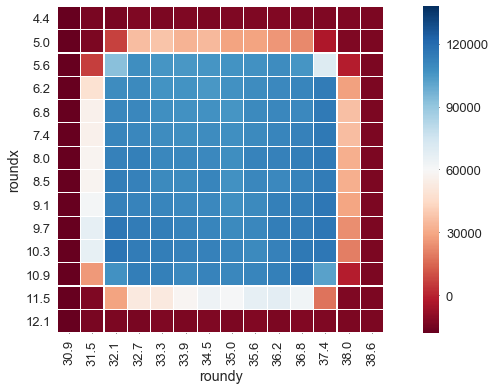

In [23]:


df = pd.DataFrame(event_list)



# pivot = pd.pivot_table(df,values='I_sum',index='y',columns='x')
# #for d in event_list:
# sns.lmplot('x', 'y', data=df, fit_reg=False)


plt.figure(figsize=(14,6))
grid_heatmap_2 = (df.pivot('roundx','roundy','I_sum'))

pivot = pd.pivot_table(df,values='I_sum',index='roundx',columns='roundy')

ax = sns.heatmap(pivot, annot = False,annot_kws={"size": 9}, fmt=".2f", 
            linewidths=0.1, square = True,
            cmap = 'RdBu', cbar = True, center = 60000);
# # ax.invert_xaxis()
# # ax.invert_yaxis()
plt.savefig('E075A_phase.pdf',format='pdf')
# sns.heatmap([df.y, df.x], annot=True)

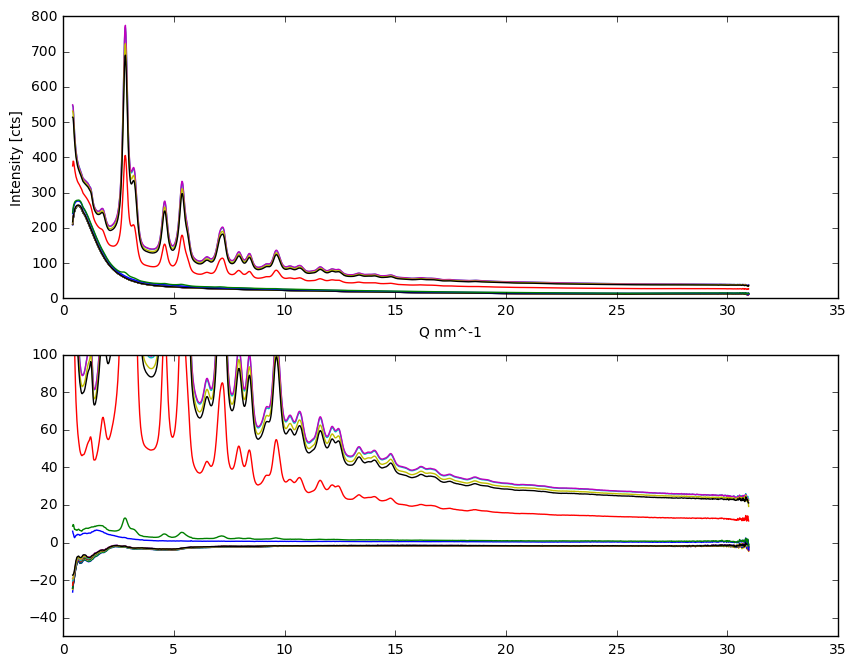

In [45]:
fig, ((ax1),(ax2)) = plt.subplots(2, 1, figsize=[10,8])
# fig, ax1 = plt.subplots(1, 1, figsize=[10,8])

# pprint(event_list)

# [detect_peaks(d['I'],mpd=5,mph=100,show=True) for d in event_list if d['position'] == '2_4']
# detect_peaks(d[0]['I'], show=True)

for d in event_list[0:21]:
    ax1.plot(d['q'],d['I'])#,label='sub_bgr_'+d['basename'],lw=1)
    ax2.plot(d['q'],d['I_sub'])#,label='sub_bgr_'+d['basename'],lw=1)  # unscaled for reference
# #plot background
# ax1.plot(qgrid_bgr,I_bgr,'ro',ms=2,label='background')
# #plot the data file
# ax1.plot(qgrid_data,I,label=basename,lw=1);
# #plot subtracted data
# ax1.plot(qgrid_data,I_sub,label='sub_bgr_'+basename,lw=1)
# ax2.plot(qgrid_data,I_sub,label='sub_bgr_'+basename,lw=1)  # unscaled for reference
# #plot scaled data with an offset
# ax2.plot(qgrid_data,I_subtr_resc-200,label='scale_sub_bgr_'+basename,lw=1)

# #configure plots
    # add axis labels using proper greek letters
    ax1.set_xlabel('Q nm^-1')
    ax1.set_ylabel('Intensity [cts]')

    ax2.set_ylim([-50,100])

    #add legend from filename
#     ax1.legend()
#     ax2.legend()

#     ax1.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#     ax2.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)




# plt.legend(fontsize = 10)
# plt.title(savefigure_name+' '+'well '+well)


# plt.savefig('test'+well+'_'+savefigure_name+'.pdf',format='pdf')

## Save output

In [18]:
with open('testCatarray_PCA', 'r') as fp:
    test_reload = pickle.load(fp)
    
#all(test_reload) == all(event_list)

# for elem in test_reload:
# #     print ele
#     print elem['position'], elem['rw']
#     print elem['rw']
#pprint([d['rw'] for d in event_list if d['position'] == '3_3'])
 

In [20]:
pprint([d for d in test_reload if d['position'] == '2_4'])

[{'Cu_U1': 0.0098485454913721272,
  'I': array([ 0.,  0.,  0., ...,  0.,  0.,  0.]),
  'I_sub': array([ 0.,  0.,  0., ...,  0.,  0.,  0.]),
  'Pt_U1': 0.0098462855913298911,
  'basename': 'sub_catalyst_array_20160803_0346',
  'composition': 'PbCu',
  'delta2_crystal1': 3.8012995362198487,
  'g': array([-0.15113441, -0.28552093, -0.42862255, ..., -0.61061431,
       -0.55839656, -0.48866157]),
  'gcalc': array([-0.89325822, -0.89014132, -0.88460123, ..., -0.31966797,
       -0.28014216, -0.23105977]),
  'gr': array([ 0.        , -0.00498147, -0.00987924, ..., -0.00901297,
       -0.01119239, -0.01262041]),
  'lattice constant': 4.0751370513297784,
  'position': '2_4',
  'psize': 116.97269792062279,
  'q': array([  1.08523830e-01,   3.25571480e-01,   5.42619170e-01, ...,
         3.20036770e+02,   3.20253810e+02,   3.20470890e+02]),
  'r': array([  0.00000000e+00,   1.00000000e-02,   2.00000000e-02, ...,
         9.99800000e+01,   9.99900000e+01,   1.00000000e+02]),
  'r_fit': array([  1

In [33]:
for k, v in d.items():
    print(k, v)

('delta2_crystal1', 5.5784008797853843)
('gr', array([ 0.        ,  0.06238923,  0.12202884, ..., -0.05541019,
       -0.06804014, -0.07895109]))
('scan', 14)
('I', array([ 0.,  0.,  0., ...,  0.,  0.,  0.]))
('basename', 'sub_catalyst_array_20160803_0501')
('psize', 119.22316873785313)
('position', '4_4')
('Pt_U1', 0.013169302394374737)
('rw', 0.76660670226263739)
('lattice constant', 4.071774873347179)
('s0', 0.19237347617365075)
('q', array([  1.08523830e-01,   3.25571480e-01,   5.42619170e-01, ...,
         3.20036770e+02,   3.20253810e+02,   3.20470890e+02]))
('Cu_U1', 0.013223574295208694)
('r', array([  0.00000000e+00,   1.00000000e-02,   2.00000000e-02, ...,
         9.99800000e+01,   9.99900000e+01,   1.00000000e+02]))
('y', -1.2630000000000001)
('x', -3.8000000000000003)
('I_subtr_resc', array([ 0.,  0.,  0., ...,  0.,  0.,  0.]))
('composition', 'PtCu')


In [34]:
event_list[1:5]

[{'Cu_U1': 0.074937948803480967,
  'I': array([ 0.,  0.,  0., ...,  0.,  0.,  0.]),
  'I_subtr_resc': array([ 0.,  0.,  0., ...,  0.,  0.,  0.]),
  'Pt_U1': 0.012399336769532294,
  'basename': 'sub_catalyst_array_20160803_0311',
  'composition': 'PtPb',
  'delta2_crystal1': 0.95867957143214666,
  'gr': array([ 0.        ,  0.0142894 ,  0.02793677, ..., -0.02294375,
         -0.02445561, -0.02489433]),
  'lattice constant': 4.0625581409879432,
  'position': '1_3',
  'psize': 32.586526091629352,
  'q': array([  1.08523830e-01,   3.25571480e-01,   5.42619170e-01, ...,
           3.20036770e+02,   3.20253810e+02,   3.20470890e+02]),
  'r': array([  0.00000000e+00,   1.00000000e-02,   2.00000000e-02, ...,
           9.99800000e+01,   9.99900000e+01,   1.00000000e+02]),
  'rw': 0.85821433109826228,
  's0': 0.1578141823293896,
  'scan': 1,
  'x': -32.518999999999998,
  'y': 8.7370000000000001},
 {'Cu_U1': 0.11586831894643035,
  'I': array([ 0.,  0.,  0., ...,  0.,  0.,  0.]),
  'I_subtr_resc'

### Anton Testing Shit

In [36]:
for d in event_list[22:66]:
    print d

{'delta2_crystal1': 3.953423250611444, 'gr': array([ 0.        , -0.00356038, -0.00706054, ..., -0.00609541,
       -0.00762392, -0.0086282 ]), 'scan': 6, 'I': array([ 0.,  0.,  0., ...,  0.,  0.,  0.]), 'basename': 'sub_catalyst_array_20160803_0346', 'psize': 417.47797216589811, 'position': '2_4', 'Pt_U1': 0.0094508449741267184, 'rw': 0.16289985935425716, 'lattice constant': 4.0751387148242921, 's0': 0.50535693315588337, 'q': array([  1.08523830e-01,   3.25571480e-01,   5.42619170e-01, ...,
         3.20036770e+02,   3.20253810e+02,   3.20470890e+02]), 'Cu_U1': 0.011677799565124339, 'r': array([  0.00000000e+00,   1.00000000e-02,   2.00000000e-02, ...,
         9.99800000e+01,   9.99900000e+01,   1.00000000e+02]), 'y': -0.26300000000000001, 'x': -22.800000000000001, 'I_subtr_resc': array([ 0.,  0.,  0., ...,  0.,  0.,  0.]), 'composition': 'PbCu'}
{'gr': array([ 0.        ,  0.00766332,  0.01494992, ..., -0.02512564,
       -0.02687908, -0.02752758]), 'scan': 6, 'I': array([ 0.,  0., 

In [12]:
pprint([d['rw'],d['basename'] for d in event_list if d['position'] == '3_1'])



SyntaxError: invalid syntax (<ipython-input-12-0d7f19fd9267>, line 1)